In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../../")
import data_loading as dl
from importlib import reload
reload(dl)

from microfit import run_plotter as rp
from microfit import histogram as hist

from microfit import variable_definitions as vdef
from microfit import selections

In [3]:
#RUN = ["3"]
RUN = ["1","2","3"] #important that it's a string 1) new format to include latest runs 2) to include 'mc_pdg' otherwise it gets dropped

rundata, mc_weights, data_pot = dl.load_runs(
    RUN,
    data="bnb",
    loadpi0variables=False,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
#    load_lee=True,
    blinded=True,
    enable_cache=True,
)

# Calculating the proton momentum component variables, where i=x,y,z

def calculate_trk_pi(row, vec_name):
    """Function to calculate the proton momentum component variables, where i=x,y,z.
        Parameters:
        -----------
        vec_name : str
            The direction variable. Can be either 'trk_dir_x_v', 'trk_dir_y_v' or 'trk_dir_z_v'.

        Returns:
        --------
        trk_pi : float
            The momentum component of the specified direction.
    """
    trk_id = row['trk_id'] -1
    trk_vec = row[vec_name]
    trk_p = row['mod_trk_p']
    
    # Access the 'trk_id'-th element of the 'trk_vec' vector and multiply it by 'trk_p'
    # But first check if trk_id is within the valid range of 'trk_vec'
    if 0 <= trk_id < len(trk_vec):
        trk_pi = trk_p * trk_vec[trk_id]
    else:
        trk_pi = np.nan  # Set to NaN for out-of-bounds indices
    
    return trk_pi

def calculate_pt(row, particle):
    """Function to calculate the transverse projection vector of the electron and proton momenta. 
        This will be used in calculating the TKI variable delta_pt.
        Parameters:
        -----------
        particle : str
            The particle for which the transverse momentum needs to be calculated. Can be either 'electron' or 'proton'.

        Returns:
        --------
        pt: numpy array of floats
            The transverse projection of the particle momentum.
    """
    
    if particle == 'electron':
        px = row['shr_px']
        py = row['shr_py']
        
    elif particle == 'proton':
        px = row['trk_px']
        py = row['trk_py']
        
    pt = np.array([px, py])
    return pt

def calculate_delta_alpha(row):
    """Function to calculate the TKI variable delta_alpha."""
    return np.degrees(np.arccos(np.inner(-1 * row['shr_pt'], row['delta_pt']) / (np.linalg.norm(row['shr_pt']) * row['mod_delta_pt'])))


for key, df in rundata.items():
    if key!='data':
        
        # Keeping only the neutrino primary daughter particles:
        #df = df[df['pfp_generation_v'].apply(lambda x: all(elem == 2 for elem in x))]
        
        # Calculating truth variables needed for signal definition
        # This should ideally go in data_loading.py
        
        Me = 0.511e-3
        Mp = 0.938
        Mpi = 0.140

        df["mc_proton_p"] = np.sqrt((df["proton_e"]) ** 2 - Mp**2)
        df["mc_electron_p"] = np.sqrt((df["elec_e"]) ** 2 - Me**2)
        df["mc_electron_ke"] = df["elec_e"] - Me
        df["mc_pion_p"] = np.sqrt((df["pion_e"]) ** 2 - Mpi**2)
        
        # Calculating the modulus of the proton momentum using trk_energy as the kinetic energy
        m_p = 0.938 # GeV (natural units c=1)
        gamma = (df['trk_energy'] / m_p) + 1
        beta = np.sqrt(1 - (1/gamma**2))
        df['mod_trk_p'] = m_p * gamma * beta # c=1

        df['trk_px'] = df.apply(calculate_trk_pi, axis=1, vec_name='trk_dir_x_v')
        df['trk_py'] = df.apply(calculate_trk_pi, axis=1, vec_name='trk_dir_y_v')
        df['trk_pz'] = df.apply(calculate_trk_pi, axis=1, vec_name='trk_dir_z_v')
        
        # Making corrections to the electron energy and momentum variables
        
        df['shr_px'] = df['shr_px'] * df['shr_energy_cali'] / df['shr_energy'] / 0.83
        df['shr_py'] = df['shr_py'] * df['shr_energy_cali'] / df['shr_energy'] / 0.83
        df['shr_pz'] = df['shr_pz'] * df['shr_energy_cali'] / df['shr_energy'] / 0.83
        
        df['shr_energy_cali'] = df['shr_energy_cali'] * 1/0.83
        
        # Calculating the modulus of the electron momentum
        df['mod_shr_p'] = np.sqrt((df['shr_px'])**2 + (df['shr_py'])**2 + (df['shr_pz'])**2)
        
        # Calculating the transverse momentum projection of the electron and proton
        df['shr_pt'] = df.apply(calculate_pt, axis=1, particle='electron')
        df['trk_pt'] = df.apply(calculate_pt, axis=1, particle='proton')
        
        # Calculating TKI delta_pt
        df['delta_pt'] = df['shr_pt'] + df['trk_pt']
        df['mod_delta_pt'] = df['delta_pt'].apply(lambda vec: np.linalg.norm(vec))
        
        # Calculating TKI delta_alpha
        df['delta_alpha'] = df.apply(calculate_delta_alpha, axis=1)
        
        # Calculating other variables required for analysis (resolution studies)
        df["mc_elec_unit_pz"] = df["elec_pz"] / df["mc_electron_p"]
        df["reco_elec_unit_pz"] = df["shr_pz"] / df["mod_shr_p"]
        
        df["hybrid_elec_pz_v1"] = df["mc_elec_unit_pz"] * df["mod_shr_p"]
        df["hybrid_elec_pz_v2"] = df["reco_elec_unit_pz"] * df["mc_electron_p"]

/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
print(rundata.keys())
#from particle import Particle
print("mc_pdg" in rundata["mc"].columns)

# from microfit import selections as sel

# selection = "OnePT"
# preselection = "OneP"
# query = f"{sel.selection_categories[selection]['query']}"
# print(query)
# print()

# selection = "OnePL"
# preselection = "OneP"
# query2 = f"{sel.selection_categories[selection]['query']}"
# print(query2)

# print(query == query2)

dict_keys(['data', 'ext', 'mc', 'nue', 'drt'])
True


In [20]:
# Getting the required data for event displays for the giveme_filtered_events.sh script

from microfit import selections as sel

selection = "OnePL"
preselection = "OneP"
query = f"{sel.preselection_categories[preselection]['query']} and {sel.selection_categories[selection]['query']}"
#print(query)

all_mc = pd.concat([df for k, df in rundata.items() if k!='data' or k!='ext'])
all_predict = all_mc.query(query, engine='python')

pred_res = all_predict['interaction'] == 1
tot_res = np.sum(all_predict.loc[pred_res, 'weights'])
print('Total resonance events:', tot_res)

all_predict.loc[pred_res, ['dataset', 'interaction', 'truthFiducial', 'isVtxInFiducial', 'run', 'sub', 'evt']].head(60)

filtered = all_predict.loc[pred_res, ['run', 'sub', 'evt']]
# filtered.to_csv(f"run{RUN[0]}_rse.txt", sep="\t", index=None, header=None)
#filtered.iloc[:50, :].to_csv(f"run{RUN[0]}_rse.txt", sep=" ", index=None, header=None)

event = all_predict.loc[pred_res, ['run', 'sub', 'evt', 'mc_pdg', 'nu_pdg', 'npi0']].query('run==18619 and sub==178 and evt==8948')
event.head()

Total resonance events: 22.10890107519493


,run,sub,evt,mc_pdg,nu_pdg,npi0
entry,,,,,,
2459,18619,178,8948,"[14, 2212, 111]",14,1


In [6]:
# Plotting the resolution of TKI ingredients

from microfit import selections as sel

#print(sel.selection_categories)

selection = "OnePL"
preselection = "OneP"
query = f"{sel.preselection_categories[preselection]['query']} and {sel.selection_categories[selection]['query']}"
#print(query)

all_mc = pd.concat([df for k, df in rundata.items() if k!='data'])
all_predict = all_mc.query(query, engine='python')
print("mod_trk_p" in all_predict.columns)

variables = {
# #    '': {'reco': , 'truth': , 'nbins': , 'bounds': },
# #     'Proton Kinetic Energy': {'reco': 'trk_energy', 'truth': 'proton_ke', 'nbins': 10, 'bounds': (0, 1)},
#     'Proton Momentum': {'reco': 'mod_trk_p', 'truth': 'mc_proton_p', 'nbins': 20, 'bounds': (0, 1.5)},
# #     'Proton X Momentum': {'reco': 'trk_px', 'truth': , 'nbins': 20, 'bounds': (-1, 1)},
# #     'Proton Y Momentum': {'reco': 'trk_py', 'truth': , 'nbins': 20, 'bounds': (-1.5, 1.5)},
# #     'Proton Z Momentum': {'reco': 'trk_pz', 'truth': , 'nbins': 20, 'bounds': (-1, 1.5)},
# #     'Electron Kinetic Energy': {'reco': 'shr_energy_cali', 'truth': 'mc_electron_ke', 'nbins': 16, 'bounds': (0, 4)},
#     'Electron Momentum': {'reco': 'mod_shr_p', 'truth': 'mc_electron_p', 'nbins': 20, 'bounds': (0, 5)},
#     'Electron X Momentum': {'reco': 'shr_px', 'truth': 'elec_px', 'nbins': 12, 'bounds': (-1.5, 1.5)},
#     'Electron Y Momentum': {'reco': 'shr_py', 'truth': 'elec_py', 'nbins': 12, 'bounds': (-1.5, 1.5)},
    'Electron Z Momentum': {'reco': 'shr_pz', 'truth': 'elec_pz', 'nbins': 12, 'bounds': (-1, 5)},
#     '$\\delta p_T$': {'reco': 'mod_delta_pt', 'truth': , 'nbins': 20, 'bounds': (0, 2)},
#     '$\\delta \\alpha_T$': {'reco': 'delta_alpha', 'truth': , 'nbins': 20, 'bounds': (0, 180)},
    
#     'Hybrid Electron Z Momentum v1': {'reco': 'hybrid_elec_pz_v1', 'truth': 'elec_pz', 'nbins': 12, 'bounds': (-1, 5)},
#     'Hybrid Electron Z Momentum v2': {'reco': 'hybrid_elec_pz_v2', 'truth': 'elec_pz', 'nbins': 12, 'bounds': (-1, 5)},
}

#print(variables['Proton Kinetic Energy']['reco'])

for k, var in variables.items():
    #print(type(k))
    truth = variables[k]['truth']
    reco = variables[k]['reco']
    #resolution = (all_predict[reco] - all_predict[truth]) / all_predict[truth]
    resolution = (abs(all_predict[reco]) - abs(all_predict[truth])) / abs(all_predict[truth])
    mean = np.mean(resolution)
    std = np.std(resolution)
    rms = np.sqrt(np.mean(np.square(resolution)))
    
    text = f"Mean: {mean:.2f} \n Std: {std:.2f} \n RMS: {rms:.2f}"
    plt.text(0.95, 0.95, text, ha='right', va='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor="white", edgecolor="none", alpha=0.8))
    plt.hist(resolution, bins=20, range=(-1, 1))
    plt.xlabel(f'(Reco - True) / True {k}')
    plt.ylabel('Frequency')
    #plt.yscale('log')
    plt.title(f"{sel.preselection_categories[preselection]['title']} and {sel.selection_categories[selection]['title']}")
    plt.savefig(f'plots/resolution_plots/Run123_abs_{preselection}_{selection}_{k}.pdf', bbox_inches='tight')
    
    plt.clf()

True


<Figure size 640x480 with 0 Axes>

{'reco': 'shr_energy_cali', 'truth': 'mc_electron_ke', 'nbins': 16, 'bounds': (0, 4)}


(array([2.700e+01, 1.430e+02, 2.730e+02, 5.800e+02, 9.430e+02, 1.628e+03,
        2.670e+03, 4.019e+03, 3.573e+03, 1.127e+03, 2.700e+02, 8.200e+01,
        2.400e+01, 1.300e+01, 4.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.92358022, -0.80730411, -0.69102799, -0.57475187, -0.45847576,
        -0.34219964, -0.22592353, -0.10964741,  0.0066287 ,  0.12290482,
         0.23918094,  0.35545705,  0.47173317,  0.58800928,  0.7042854 ,
         0.82056151,  0.93683763,  1.05311374,  1.16938986,  1.28566598,
         1.40194209,  1.51821821,  1.63449432,  1.75077044,  1.86704655,
         1.

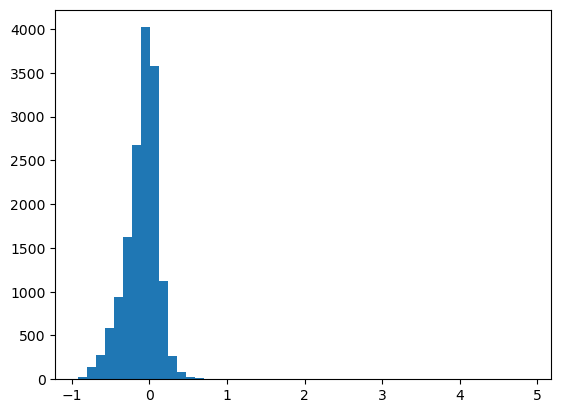

In [22]:
print(variables['Electron Kinetic Energy'])
resol = (all_predict['mod_shr_p'] - all_predict['mc_electron_p']) / all_predict['mc_electron_p']
plt.hist(resol, 50)

In [8]:
# Calculating efficiency and purity

from microfit import selections as sel

selection = "OnePT"
preselection = "OneP"
query = f"{sel.preselection_categories[preselection]['query']} and {sel.selection_categories[selection]['query']}"
#print(query)

all_mc = pd.concat([df for k, df in rundata.items() if k!='data'])
all_predict = all_mc.query(query, engine='python')
all_predict = all_predict[all_predict['pfp_generation_v'].apply(lambda x: all(elem == 2 for elem in x))]
#all_predict.head()

all_sig = all_mc['category_1e1p'] == 12
tot_all_sig = np.sum(all_mc.loc[all_sig, 'weights'])
print('Total candidate signal events:', tot_all_sig)

is_sig = all_predict['category_1e1p'] == 12
tot_sig = np.sum(all_predict.loc[is_sig, 'weights'])
tot_bkg = np.sum(all_predict.loc[~is_sig, 'weights'])
tot_evt = np.sum(all_predict['weights'])
print('After cuts:')
print('Total signal events:', tot_sig)
print('Total background events:', tot_bkg)
print('Total events:', tot_evt)
print('sig + bkg =', tot_sig+tot_bkg)
print()

efficiency = (tot_sig / tot_all_sig) * 100
purity = (tot_sig / tot_evt) * 100
print('Efficiency:', efficiency)
print('Purity:', purity)
print()

pred_res = all_predict['interaction'] == 1
tot_res = np.sum(all_predict.loc[pred_res, 'weights'])
print('Total resonance events:', tot_res)
pred_qe = all_predict['interaction'] == 0
tot_qe = np.sum(all_predict.loc[pred_qe, 'weights'])
print('Total quasielastic events:', tot_qe)

print('QE/RES =', tot_qe/tot_res)
print('RES/QE =', tot_res/tot_qe)

# for binning_def in vdef.variables_1e1p:
# #     lb = binning_def[2][0]
# #     ub = binning_def[2][1]
# #     print(lb, ub)
    
#     x_plot = np.linspace(binning_def[2][0], binning_def[2][1], 100)
#     eff = []
#     pur = []
#     bkg_eff = []
    
#     for x in x_plot:
#         sig_below = np.sum(all_predict.loc[is_sig & (all_predict[binning_def[0]] < x), 'weights'])
#         bkg_below = np.sum(all_predict.loc[~is_sig & (all_predict[binning_def[0]] < x), 'weights'])
        
#         eff.append(sig_below/tot_sig)
#         pur.append(sig_below/(sig_below + bkg_below))
#         bkg_eff.append(bkg_below/tot_bkg)
        
    
#     fig1, ax1 = plt.subplots()
#     ax1.plot(x_plot, pur, label='signal purity')
#     ax1.plot(x_plot, eff, label='signal efficiency')
#     ax1.plot(x_plot, bkg_eff, label='background efficiency')
#     ax1.legend()
#     ax1.set_xlabel(binning_def[3])
#     #plt.ylabel('Signal Efficiency')
#     ax1.set_title('1e1p Presel. and 1e1p Loose cuts')
#     #plt.tight_layout()
#     #plt.savefig('plots/pur_eff_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
#     plt.clf()
    
#     fig2, ax2 = plt.subplots()
#     ax2.plot(eff, pur)
#     ax2.set_xlabel('Signal Efficiency')
#     ax2.set_ylabel('Signal Purity')
#     ax2.set_title('%s' %(binning_def[0]))
#     #plt.tight_layout()
#     #plt.savefig('plots/eff_vs_pur_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
#     plt.clf()
    
#     plt.plot(eff, bkg_eff)
#     plt.xlabel('Signal Efficiency')
#     plt.ylabel('Background Acceptance efficiency')
#     plt.title('%s' %(binning_def[0]))
#     plt.tight_layout()
#     #plt.savefig('plots/roc_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
#     plt.clf()

Total candidate signal events: 9093.204644680574
After cuts:
Total signal events: 41.37481005978364
Total background events: 6.590734153240682
Total events: 47.96554421302433
sig + bkg = 47.96554421302432

Efficiency: 0.4550080161671876
Purity: 86.2594404767515

Total resonance events: 7.9125835077543805
Total quasielastic events: 29.90605906795465
QE/RES = 3.7795568335735767
RES/QE = 0.26458128400585484


In [8]:
#all_predict.loc[:, ['mc_px', 'mc_py', 'mc_pz']].head(60)


evts: [40.96173528 35.29278306  0.48483358  3.98675492  1.82382681  0.59680518
 19.84856513  0.33704982  2.81840592  0.          0.          0.        ]


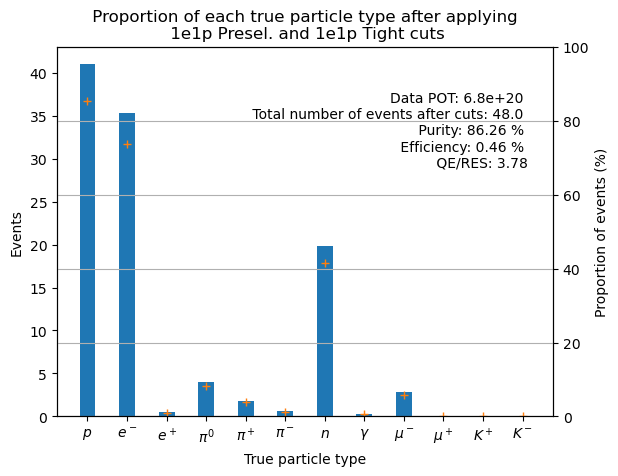

In [45]:
# Particle pdg breakdown (Elena's way)

#particle = ['proton', 'electron', 'anti electron', 'pi0', 'pi+', 'pi-', 'neutron', 'gamma', 'muon', 'anti muon', 'K+', 'K-']
particle = ['$p$', '$e^-$', '$e^+$', '$\\pi^0$', '$\\pi^+$', '$\\pi^-$', '$n$', '$\\gamma$', '$\\mu^-$', '$\\mu^+$', '$K^+$', '$K^-$']
pdg = [2212, 11, -11, 111, 211, -211, 2112, 22, 13, -13, 321, -321]
evts = np.zeros(len(pdg))
# print('Total number of events after selection:', tot_evt)
# print(data_pot)
# print(all_predict.index)
# print(all_predict.loc[37, 'weights'])

for i in all_predict.index:
    for p in range(len(pdg)):
        if pdg[p] in all_predict.loc[i, 'mc_pdg']:
            evts[p] += all_predict.loc[i, 'weights']
            
perc = (evts / tot_evt) * 100
print()
print('evts:', evts)
# print('percentage:', perc)

fig, ax = plt.subplots()

ax.bar(particle, evts, width = 0.4)
#fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')
ax.set_xlabel("True particle type")
ax.set_ylabel("Events")
text = f"Data POT: {data_pot:.1e} \n Total number of events after cuts: {tot_evt:.1f} \n Purity: {purity:.2f} % \n Efficiency: {efficiency:.2f} % \n QE/RES: {tot_qe/tot_res:.2f}"
ax.text(0.95, 0.88, text, ha="right", va="top", transform=ax.transAxes, fontsize=10, bbox=dict(facecolor="white", edgecolor="none", alpha=0.8))

ax2 = ax.twinx()

ax2.plot(particle, perc, '+', color='tab:orange')
ax2.grid()
ax2.set_ylabel('Proportion of events (%)')
ax2.set_ylim(0, 100)

presel_title = sel.preselection_categories[preselection]["title"]
sel_title = selections.selection_categories[selection]["title"]
title = f" Proportion of each true particle type after applying \n {presel_title} and {sel_title}"
plt.title(title)
plt.savefig(f'plots/tightsel_vars/Run123_pdg_Elena_{preselection}_{selection}.pdf', bbox_inches='tight')

Total number of events after selection: 158.48685184385727
6.85e+20


evts: [1.35755583e+02 6.54876341e+01 1.00927871e+00 4.52993903e+01
 9.59049357e+00 6.24378964e+00 8.09299826e+01 2.10141417e+00
 3.26679164e+01 0.00000000e+00 3.30759331e-03 3.30759331e-03]


Text(0.5, 1.0, ' Proportion of each true particle type after applying \n 1e1p Presel. and 1e1p Loose cuts')

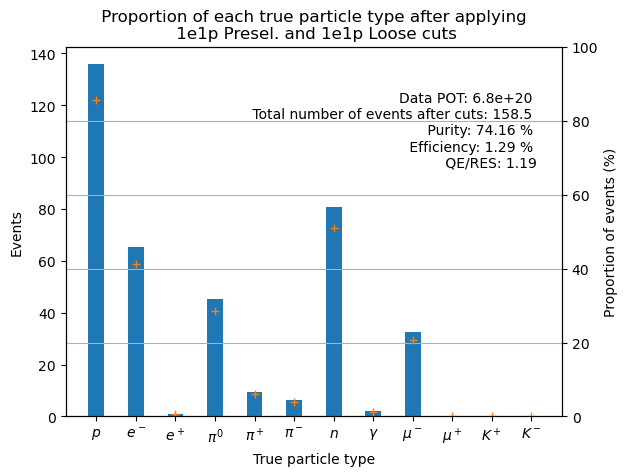

In [40]:
# Particle pdg breakdown

#particle = ['proton', 'electron', 'anti electron', 'pi0', 'pi+', 'pi-', 'neutron', 'gamma', 'muon', 'anti muon', 'K+', 'K-']
particle = ['$p$', '$e^-$', '$e^+$', '$\\pi^0$', '$\\pi^+$', '$\\pi^-$', '$n$', '$\\gamma$', '$\\mu^-$', '$\\mu^+$', '$K^+$', '$K^-$']
pdg = [2212, 11, -11, 111, 211, -211, 2112, 22, 13, -13, 321, -321]
evts = np.array([])
print('Total number of events after selection:', tot_evt)
print(data_pot)
print()

for num in pdg:
    df = all_predict[all_predict['mc_pdg'].apply(lambda x: num in x)]
    #print(len(df))
    num_evts = np.sum(df['weights'])
    evts = np.append(evts, num_evts)

perc = (evts / tot_evt) * 100
print()
print('evts:', evts)
# print('percentage:', perc)

fig, ax = plt.subplots()

ax.bar(particle, evts, width = 0.4)
#fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')
ax.set_xlabel("True particle type")
ax.set_ylabel("Events")
text = f"Data POT: {data_pot:.1e} \n Total number of events after cuts: {tot_evt:.1f} \n Purity: {purity:.2f} % \n Efficiency: {efficiency:.2f} % \n QE/RES: {tot_qe/tot_res:.2f}"
ax.text(0.95, 0.88, text, ha="right", va="top", transform=ax.transAxes, fontsize=10, bbox=dict(facecolor="white", edgecolor="none", alpha=0.8))

ax2 = ax.twinx()

ax2.plot(particle, perc, '+', color='tab:orange')
ax2.grid()
ax2.set_ylabel('Proportion of events (%)')
ax2.set_ylim(0, 100)

presel_title = sel.preselection_categories[preselection]["title"]
sel_title = selections.selection_categories[selection]["title"]
title = f" Proportion of each true particle type after applying \n {presel_title} and {sel_title}"
plt.title(title)
#plt.savefig(f'plots/tightsel_vars/Run123_pdg_{preselection}_{selection}.pdf', bbox_inches='tight')

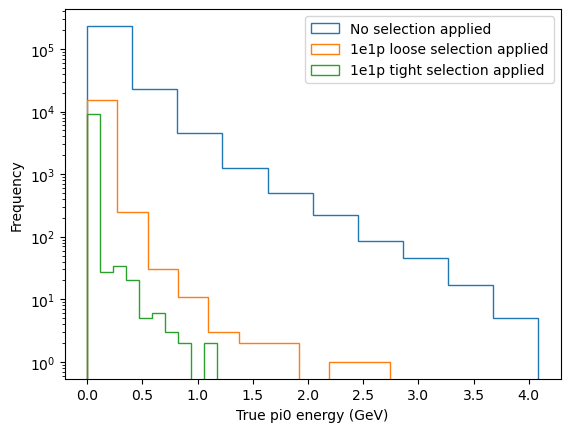

In [21]:
selection2 = "OnePT"
preselection2 = "OneP"
query2 = f"{sel.preselection_categories[preselection2]['query']} and {sel.selection_categories[selection2]['query']}"
#print(query)
all_predict_tight = all_mc.query(query2, engine='python')

plt.hist(all_mc['pi0_e'], histtype='step', label='No selection applied')
plt.hist(all_predict['pi0_e'], histtype='step', label='1e1p loose selection applied')
plt.hist(all_predict_tight['pi0_e'], histtype='step', label='1e1p tight selection applied')
plt.legend()
plt.yscale('log')
plt.xlabel('True pi0 energy (GeV)')
plt.ylabel('Frequency')
plt.savefig('plots/microfit_1e1p_pi0_e_stephist.pdf', bbox_inches='tight')

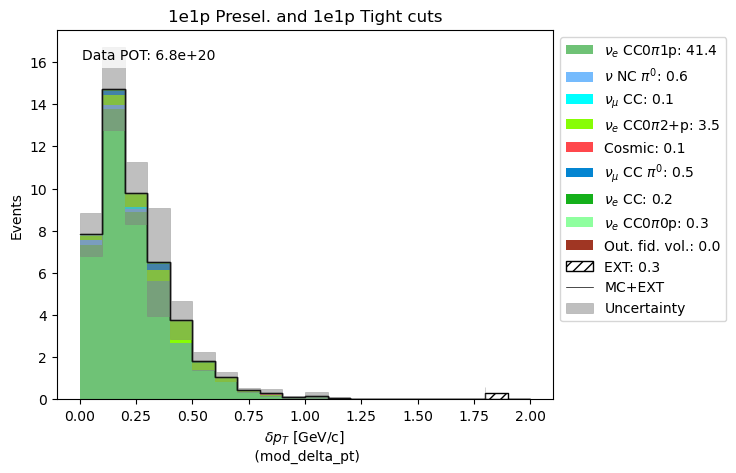

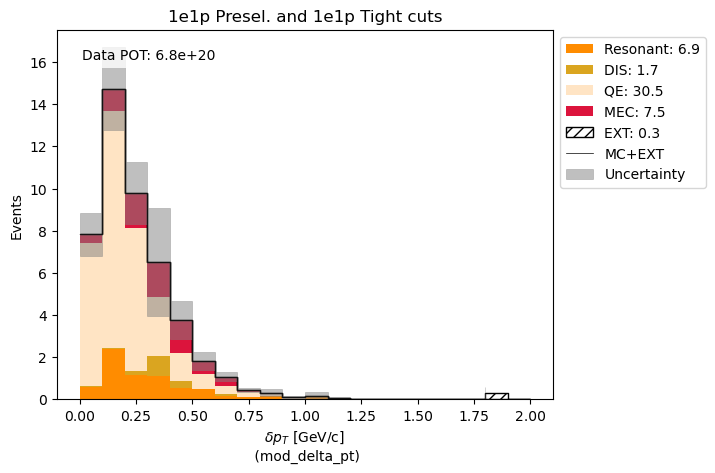

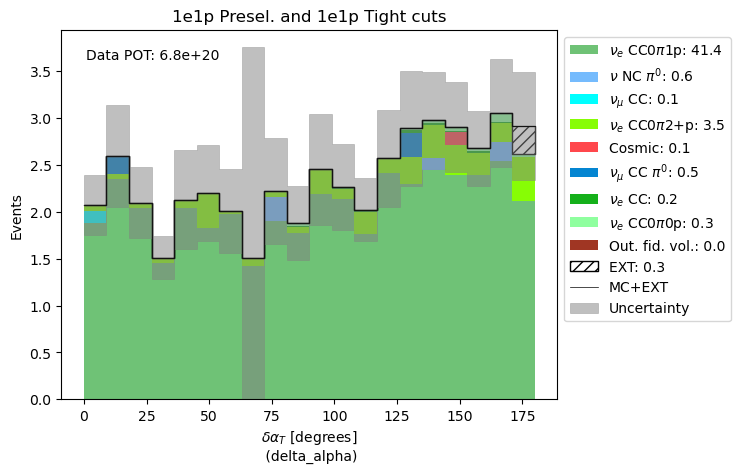

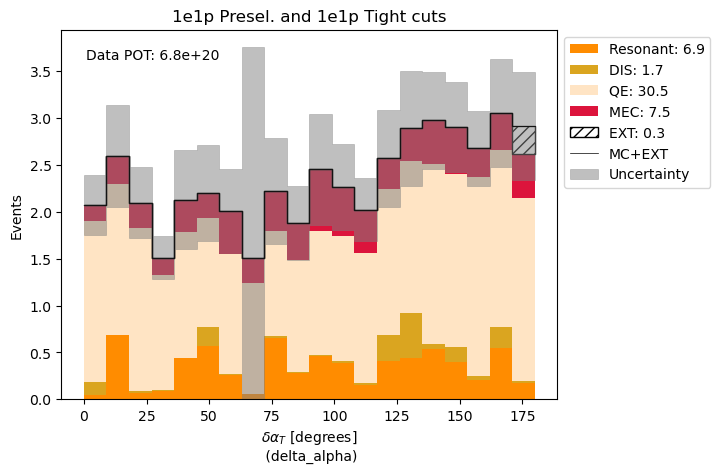

In [5]:
# Plotting TKI variables

selection = "OnePL"
preselection = "OneP"

for binning_def in vdef.TKI_variables_1e1p:
    # some binning definitions have more than 4 elements,
    # we ignore the last ones for now
    binning = hist.Binning.from_config(*binning_def[:4])
    #binning = hist.Binning.from_config(*binning_def)
    signal_generator = hist.RunHistGenerator(
        rundata,
        binning,
        data_pot=data_pot,
        selection=selection,
        preselection=preselection,
        sideband_generator=None,
        uncertainty_defaults=None,
    )
    plotter = rp.RunHistPlotter(signal_generator)
    axes = plotter.plot(
        category_column="category_1e1p",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    #plt.savefig('plots/microfit_TKI_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    #plt.savefig(f'plots/tightsel_series/Run123_TKI_{preselection}_15_shrtrklen_{binning_def[0]}.pdf', bbox_inches='tight')
    plt.show()
    
    axes2 = plotter.plot(
        category_column="interaction",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    #plt.savefig('plots/microfit_TKI_int_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    #plt.savefig(f'plots/tightsel_series/Run123_TKI_{preselection}_15_shrtrklen_{binning_def[0]}_int.pdf', bbox_inches='tight')
    plt.show()
    
    axes3 = plotter.plot(
        category_column="interaction",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    plt.savefig('plots/microfit_TKI_pdg_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    #plt.savefig(f'plots/tightsel_series/Run123_TKI_{preselection}_15_shrtrklen_{binning_def[0]}_int.pdf', bbox_inches='tight')
    plt.show()
    
#     axes3 = plotter.plot(
#         category_column="interaction",
#         include_multisim_errors=True,
#         add_ext_error_floor=False,
# #        show_data_mc_ratio=True,
#         stacked=False,
#         show_total=False
#     )
    #plt.savefig('plots/microfit_TKI_int_step_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    plt.show()

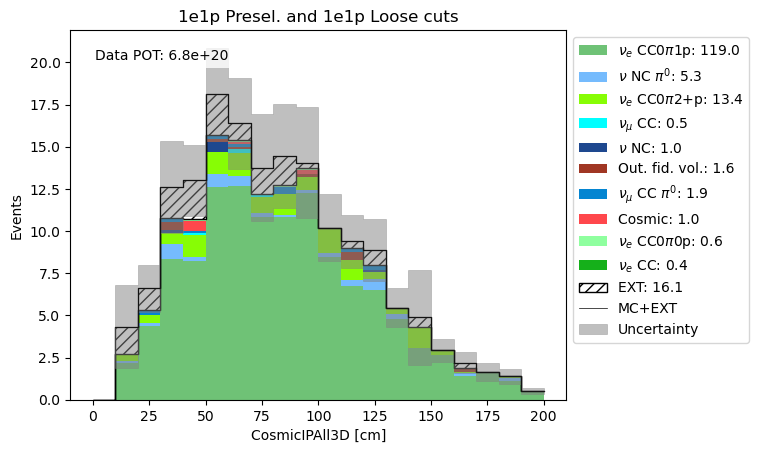

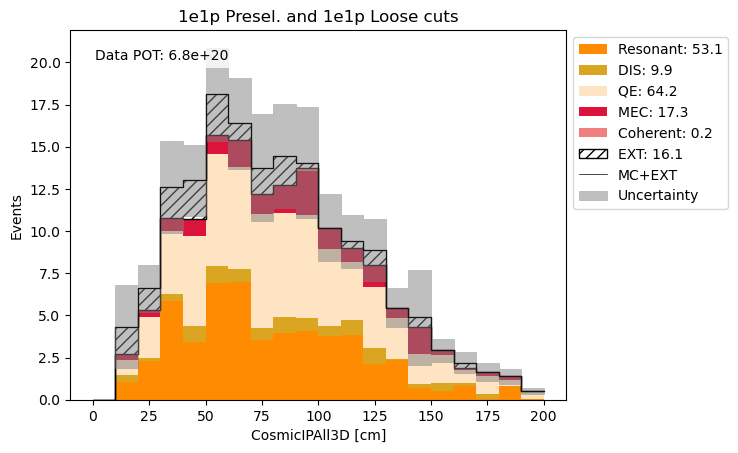

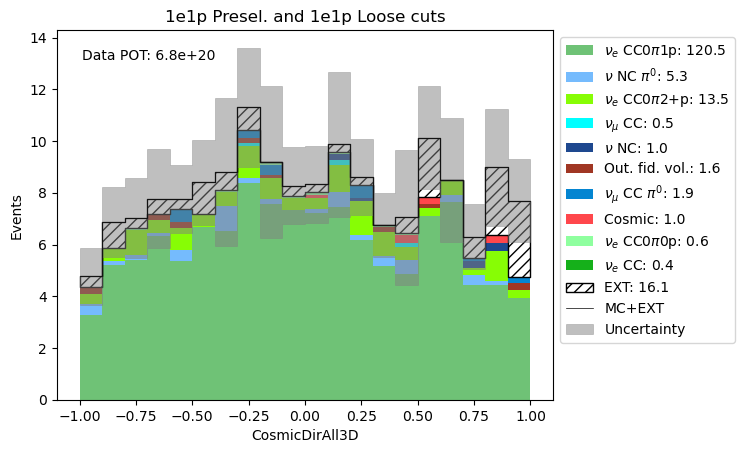

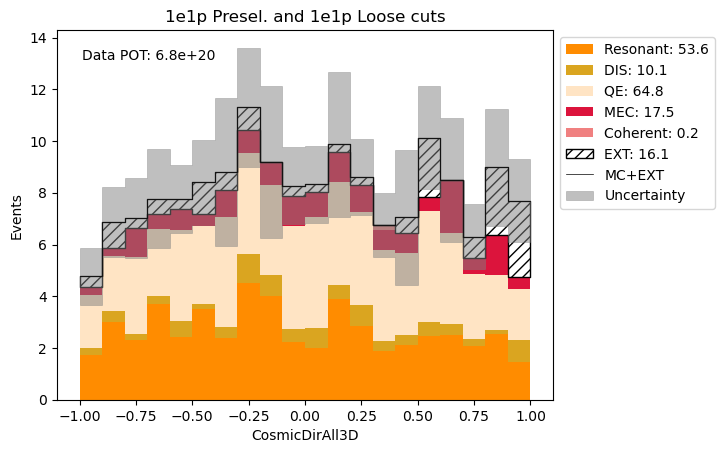

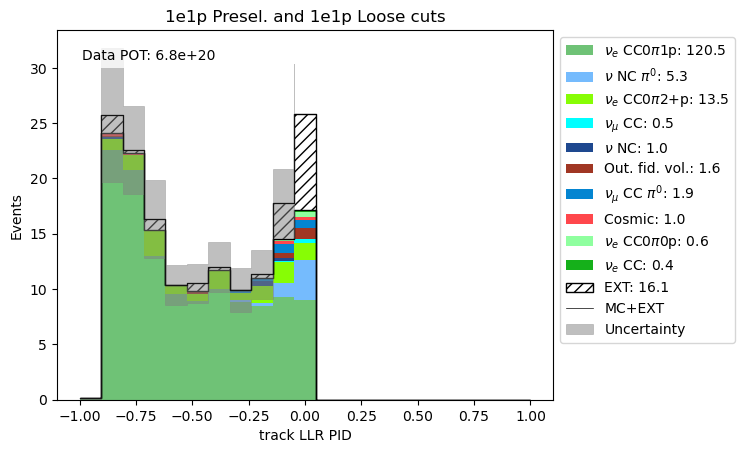

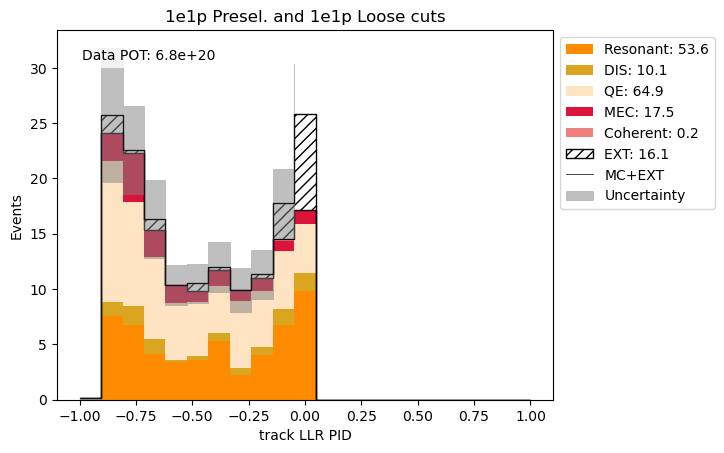

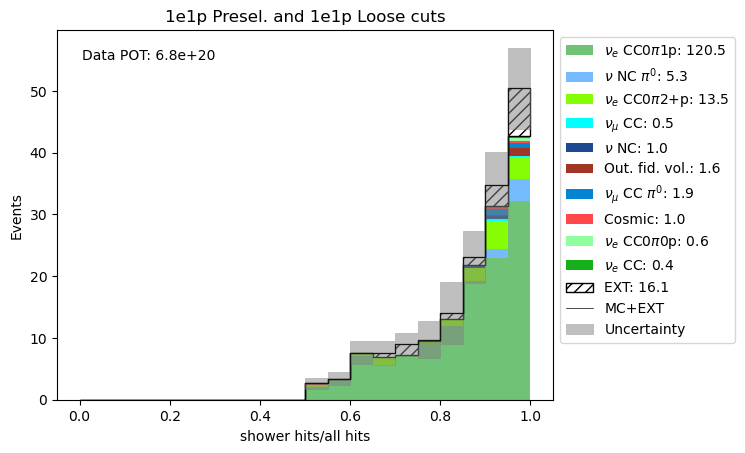

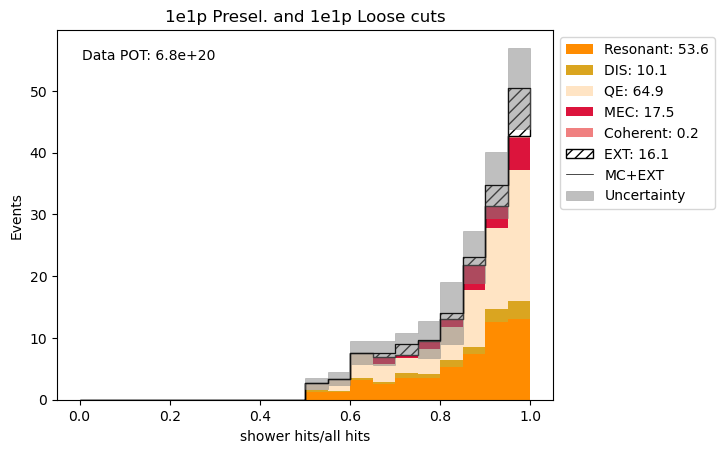

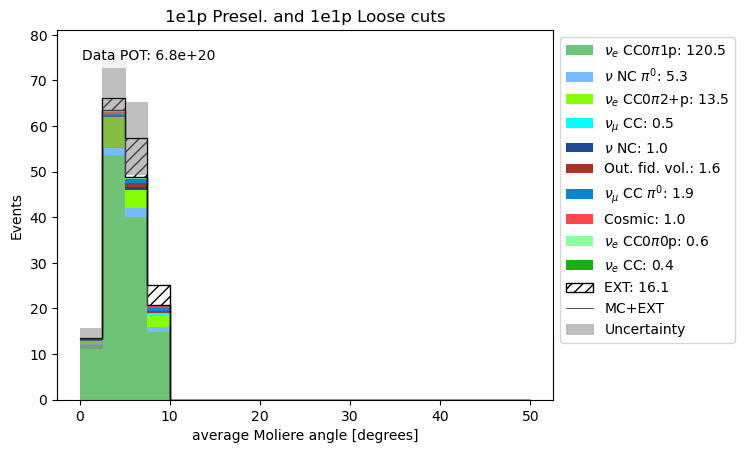

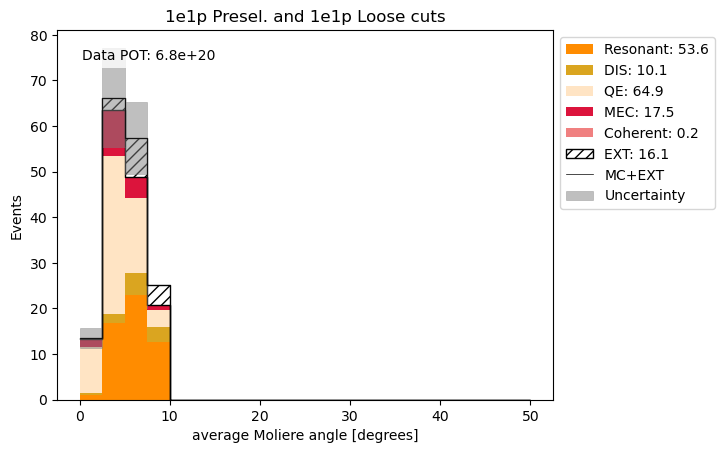

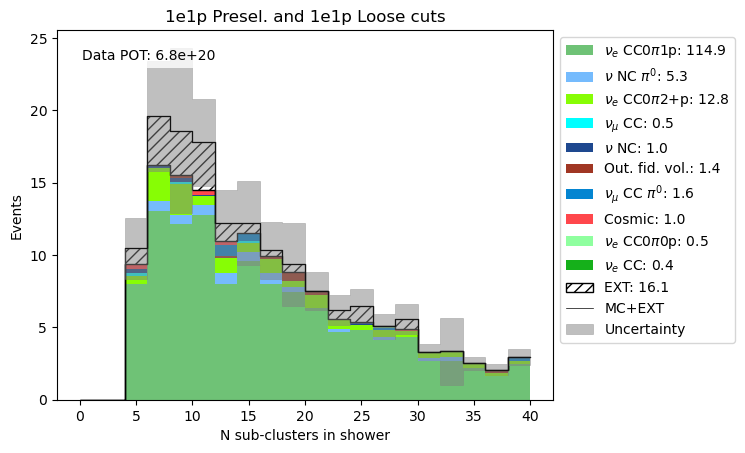

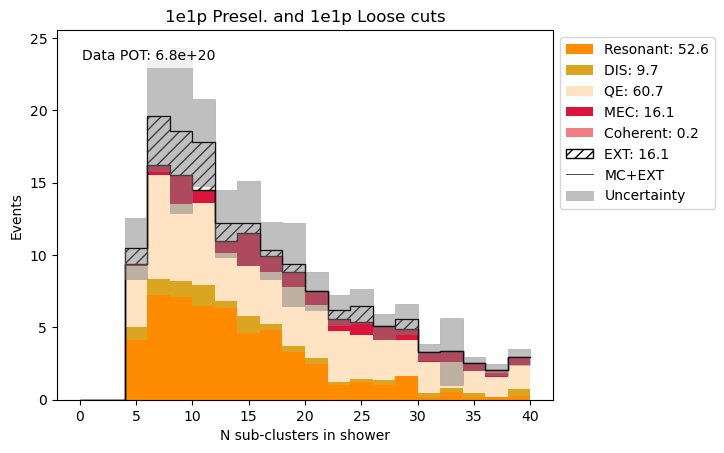

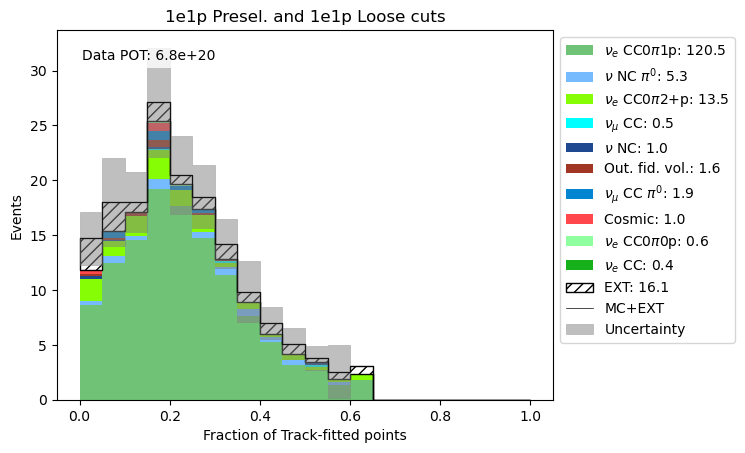

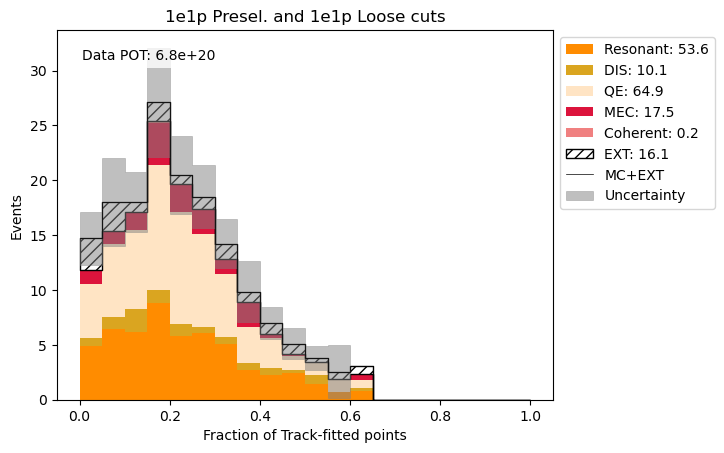

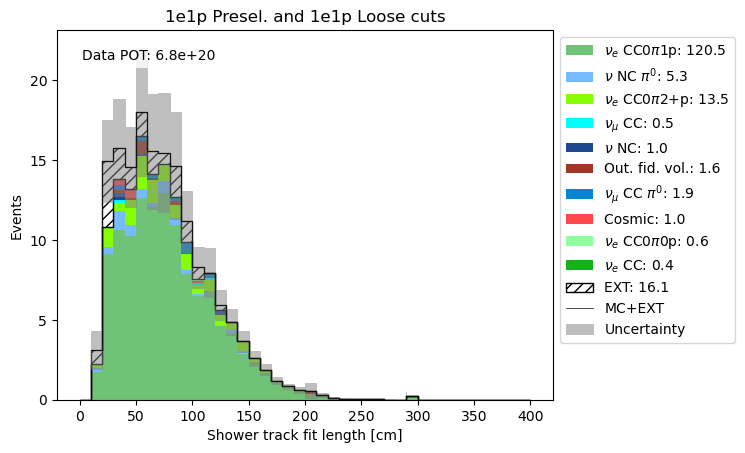

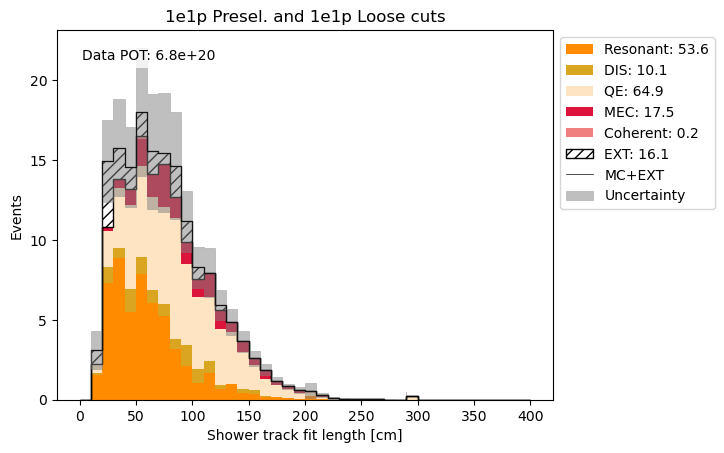

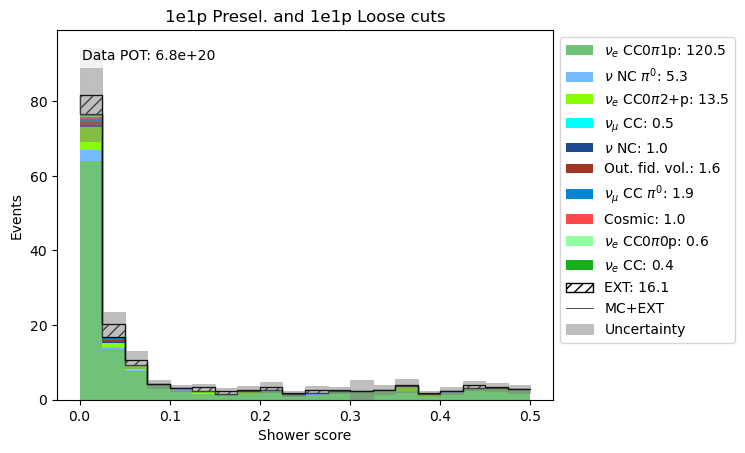

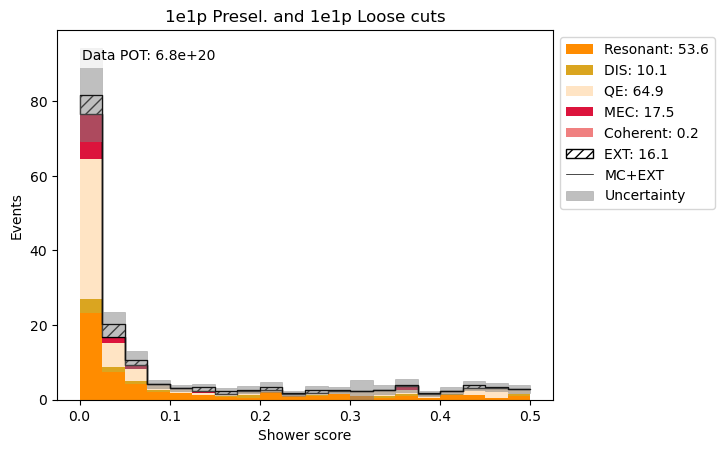

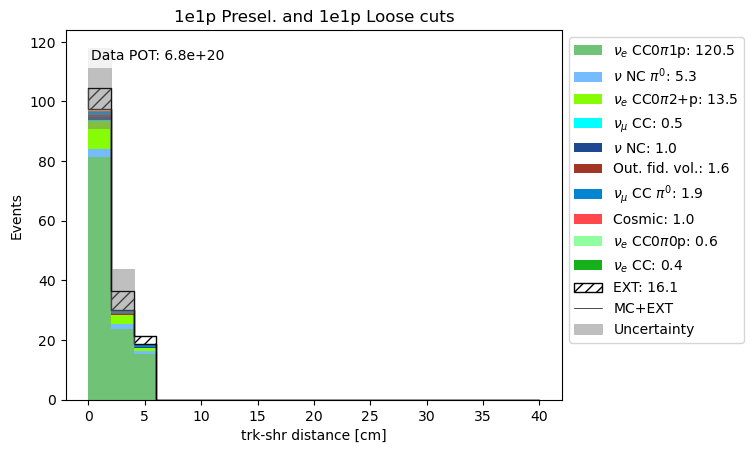

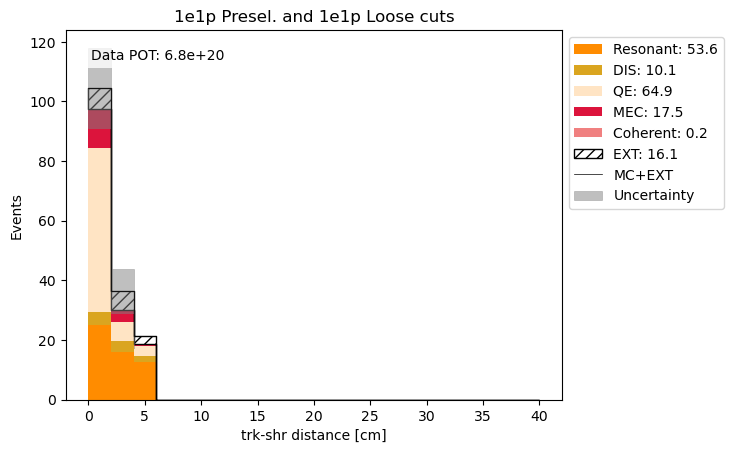

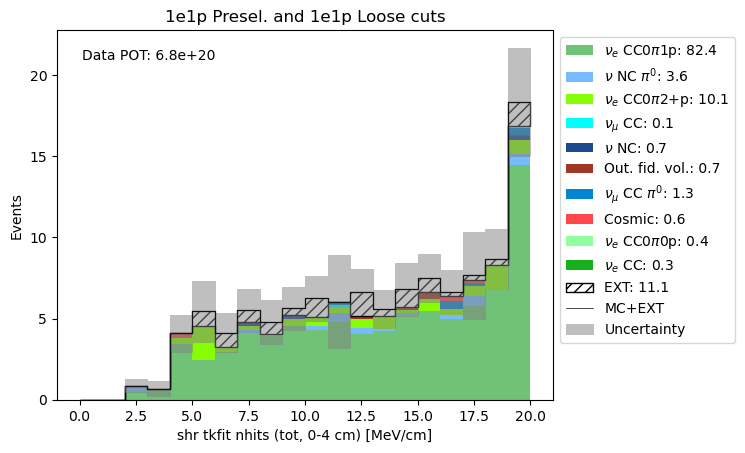

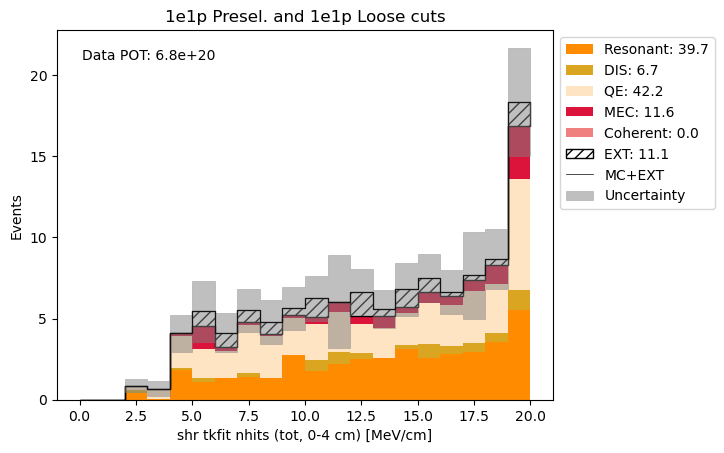

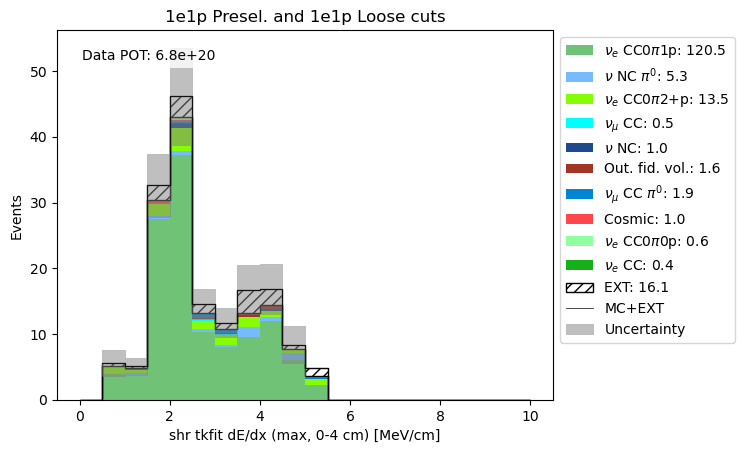

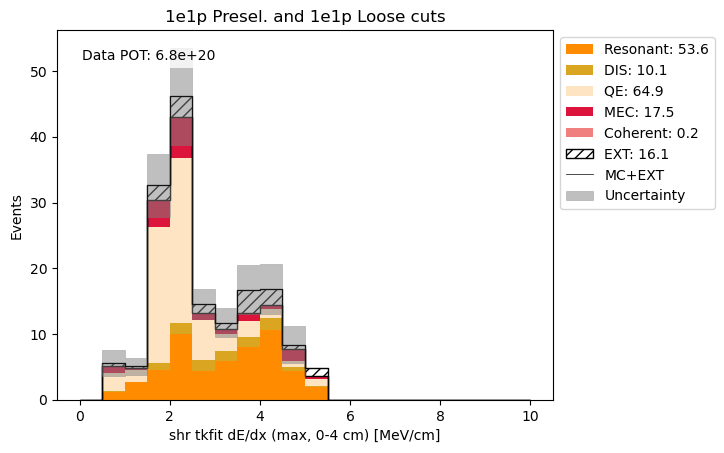

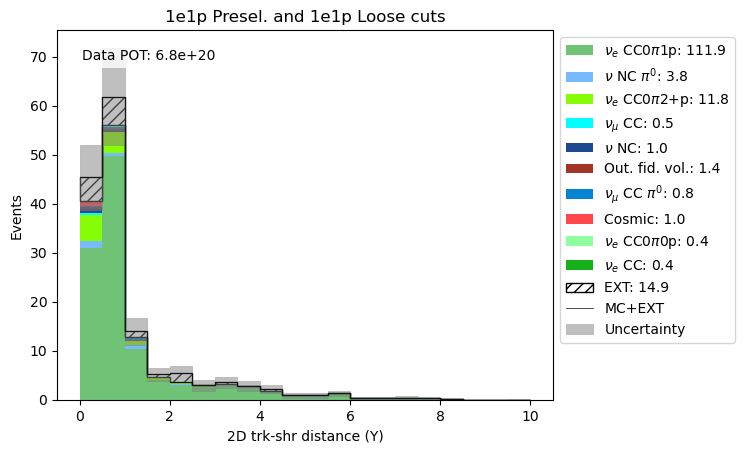

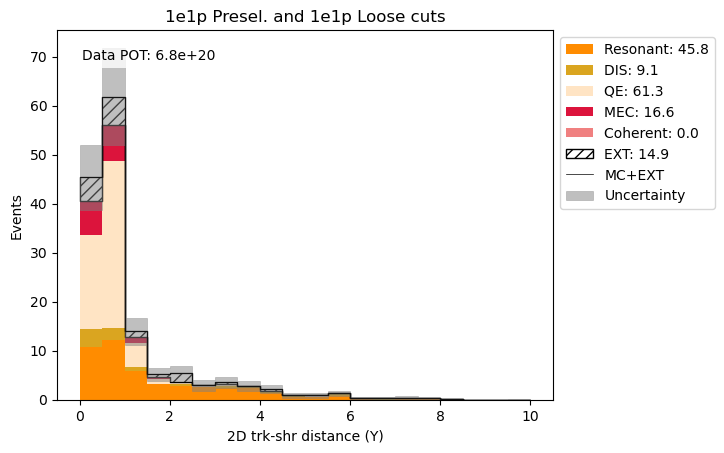

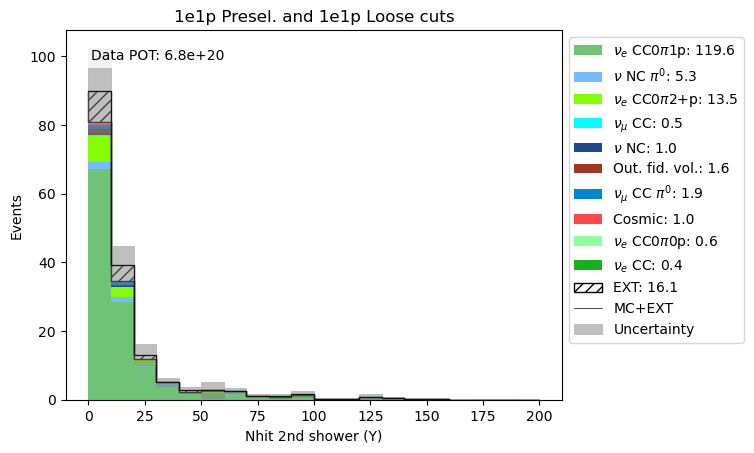

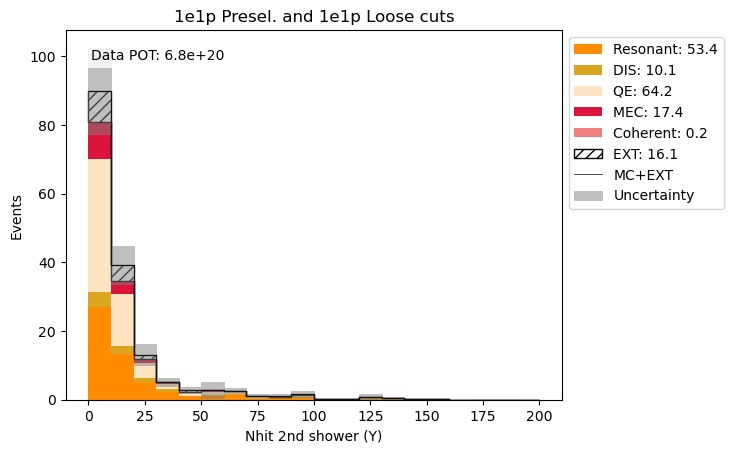

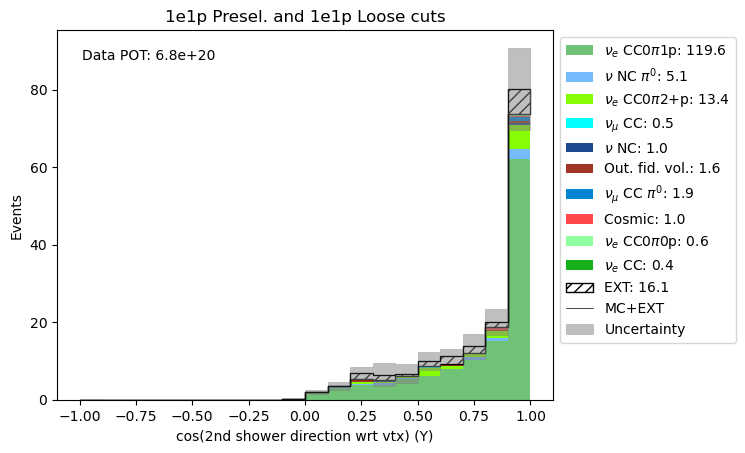

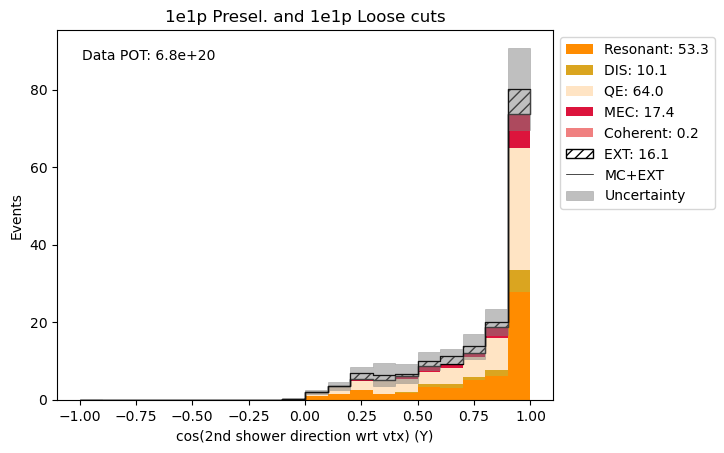

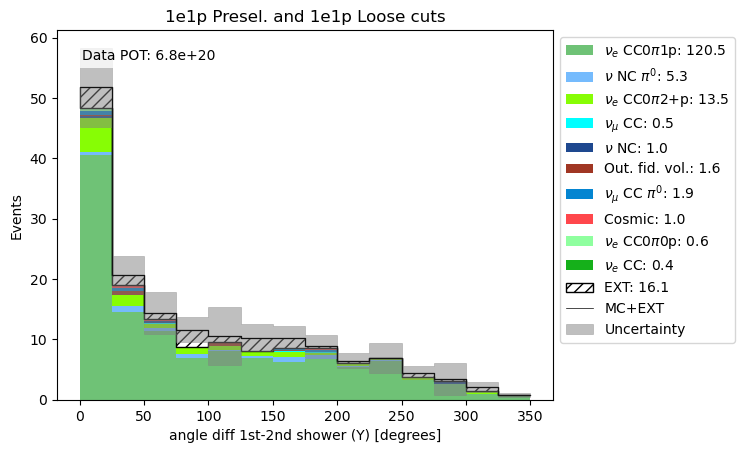

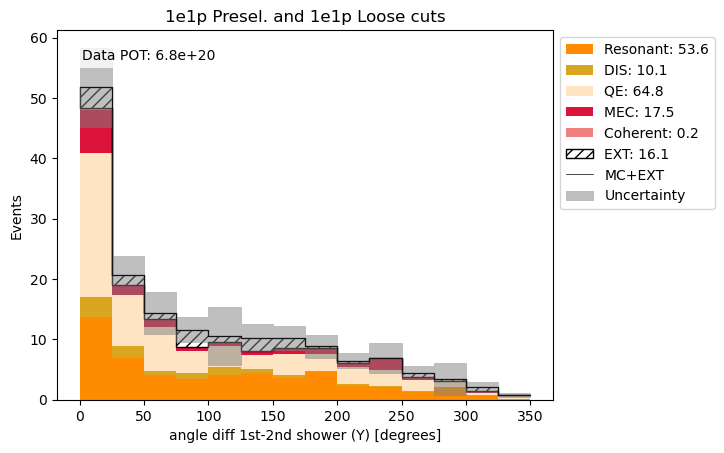

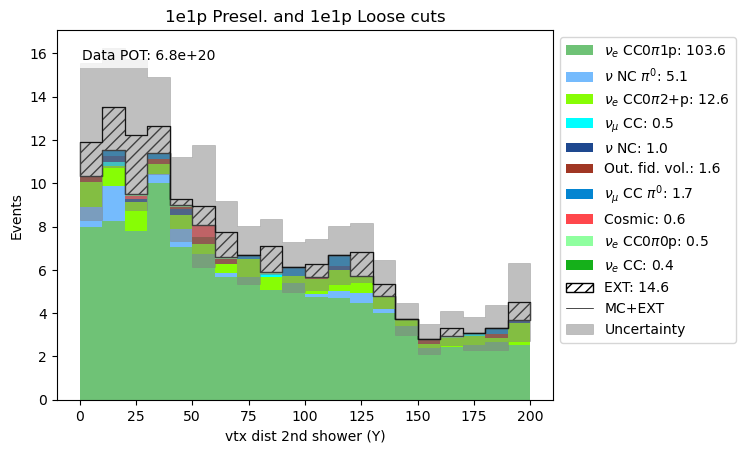

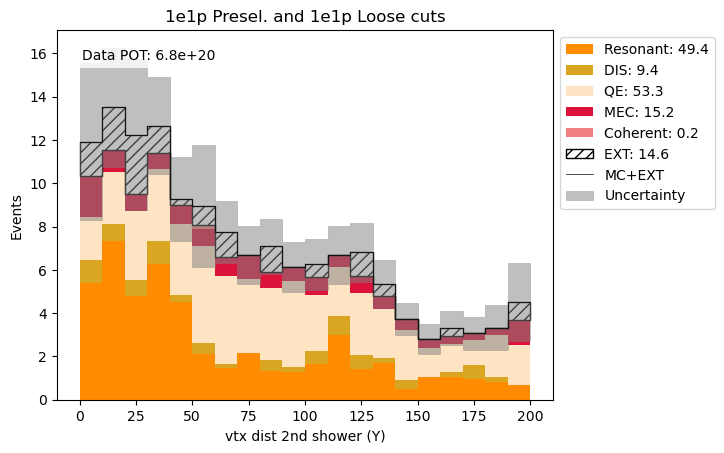

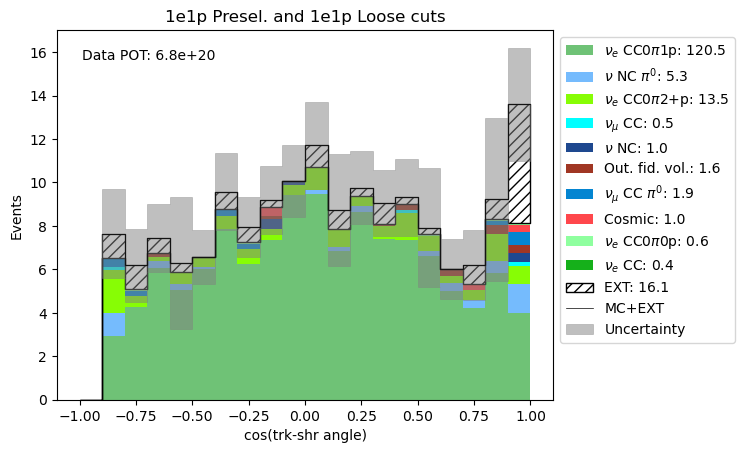

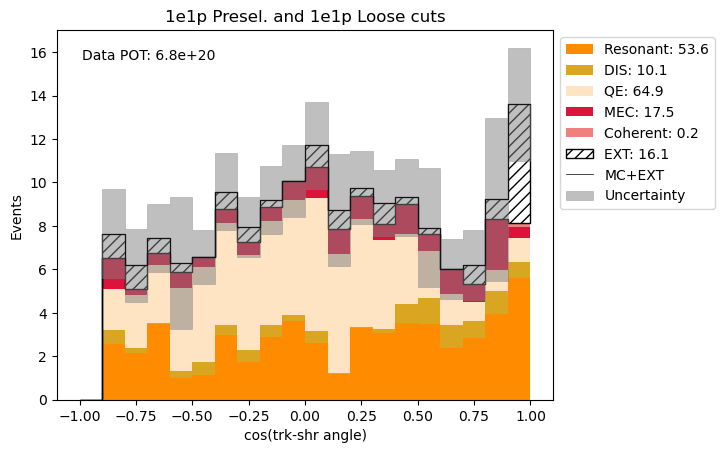

In [5]:
# plotting the tight selection variables after applying loose cuts

selection = "OnePL"
preselection = "OneP"

for binning_def in vdef.tightsel_variables:
    # some binning definitions have more than 4 elements,
    # we ignore the last ones for now
    binning = hist.Binning.from_config(*binning_def[:4])
    #binning = hist.Binning.from_config(*binning_def)
    signal_generator = hist.RunHistGenerator(
        rundata,
        binning,
        data_pot=data_pot,
        selection=selection,
        preselection=preselection,
        sideband_generator=None,
        uncertainty_defaults=None,
    )
    plotter = rp.RunHistPlotter(signal_generator)
    axes = plotter.plot(
        category_column="category_1e1p",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    #plt.savefig('plots/microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    plt.savefig(f'plots/tightsel_vars/Run123_{preselection}_{selection}_{binning_def[0]}.pdf', bbox_inches='tight')
    plt.show()
    
    axes2 = plotter.plot(
        category_column="interaction",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    #plt.savefig('plots/microfit_int_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    plt.savefig(f'plots/tightsel_vars/Run123_{preselection}_{selection}_{binning_def[0]}_int.pdf', bbox_inches='tight')
    plt.show()
    

Text(0.5, 0, 'True proton momentum (GeV/c)')

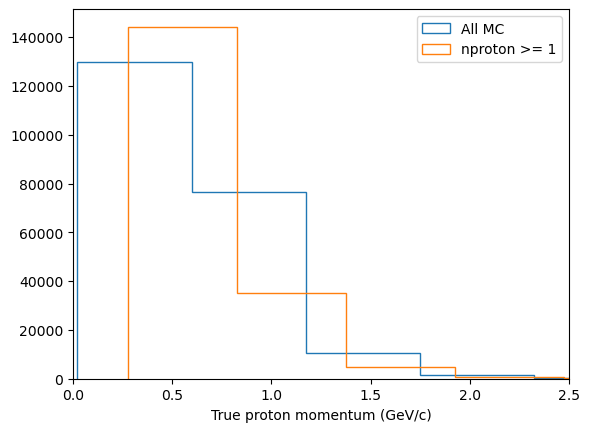

In [10]:
# Investigating how the 'nproton' variable is defined

all_mc = pd.concat([df for k, df in rundata.items() if k!='data' or k!='ext'])
plt.hist(all_mc['mc_proton_p'], histtype='step', label='All MC')
all_mc.query('nproton >= 1', inplace=True)
plt.hist(all_mc['mc_proton_p'], histtype='step', label='nproton >= 1')
plt.legend()
plt.xlim([0,2.5])
#plt.grid(visible=True, which='both', axis='x')
plt.xlabel('True proton momentum (GeV/c)')


Text(0.5, 0, 'True electron momentum (GeV/c)')

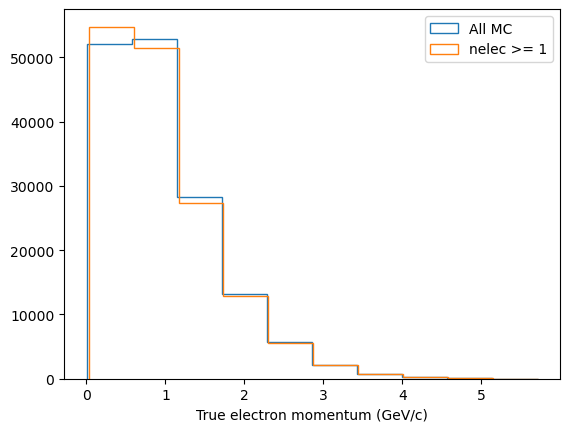

In [11]:
# Investigating how the 'nelec' variable is defined

all_mc = pd.concat([df for k, df in rundata.items() if k!='data' or k!='ext'])
plt.hist(all_mc['mc_electron_p'], histtype='step', label='All MC')
all_mc.query('nelec >= 1', inplace=True)
plt.hist(all_mc['mc_electron_p'], histtype='step', label='nelec >= 1')
plt.legend()
#plt.xlim([0,2.5])
#plt.grid(visible=True, which='both', axis='x')
plt.xlabel('True electron momentum (GeV/c)')

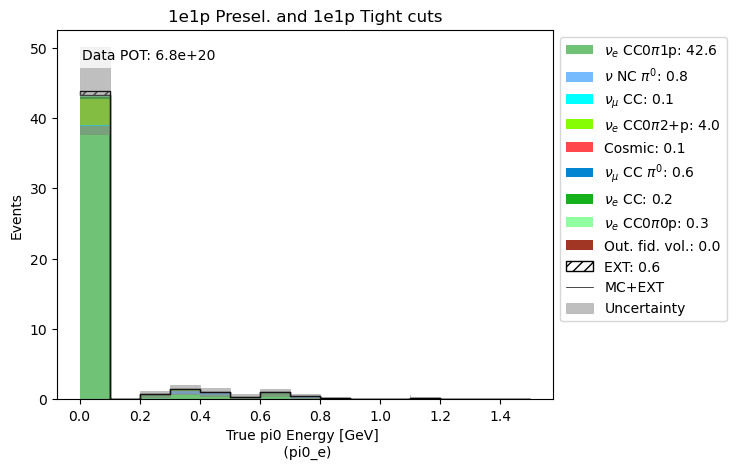

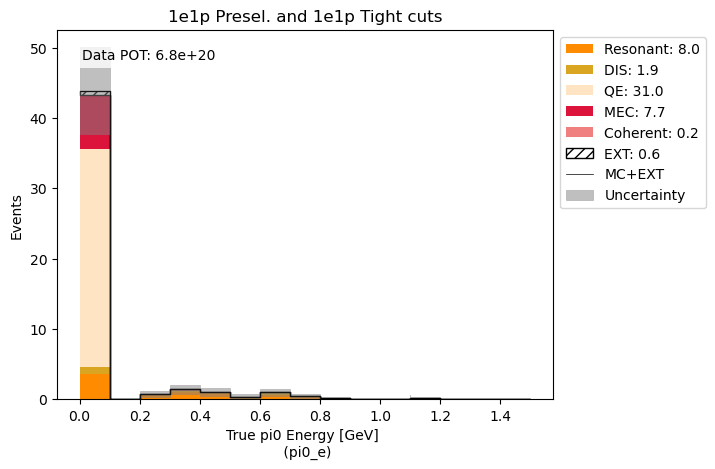

In [25]:
#selection = "NPL"
selection = "OnePT"
preselection = "OneP"

for binning_def in vdef.variables_1e1p:
    # some binning definitions have more than 4 elements,
    # we ignore the last ones for now
    binning = hist.Binning.from_config(*binning_def[:4])
    #binning = hist.Binning.from_config(*binning_def)
    signal_generator = hist.RunHistGenerator(
        rundata,
        binning,
        data_pot=data_pot,
        selection=selection,
        preselection=preselection,
        sideband_generator=None,
        uncertainty_defaults=None,
    )
    plotter = rp.RunHistPlotter(signal_generator)
    axes = plotter.plot(
        category_column="category_1e1p",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    #plt.savefig('plots/microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    #plt.savefig(f'plots/Run123_{preselection}_{selection}_{binning_def[0]}.pdf', bbox_inches='tight')
    plt.savefig(f'plots/microfit_1e1p_{binning_def[0]}_{preselection}_{selection}.pdf', bbox_inches='tight')
    plt.show()
    
    axes2 = plotter.plot(
        category_column="interaction",
        include_multisim_errors=True,
        add_ext_error_floor=False,
#        show_data_mc_ratio=True,
    )
    #plt.savefig('plots/microfit_int_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    #plt.savefig(f'plots/Run123_{preselection}_{selection}_{binning_def[0]}_int.pdf', bbox_inches='tight')
    plt.savefig(f'plots/microfit_1e1p_{binning_def[0]}_{preselection}_{selection}_int.pdf', bbox_inches='tight')
    plt.show()
    

Text(0.5, 0, 'True pion momentum (GeV/c)')

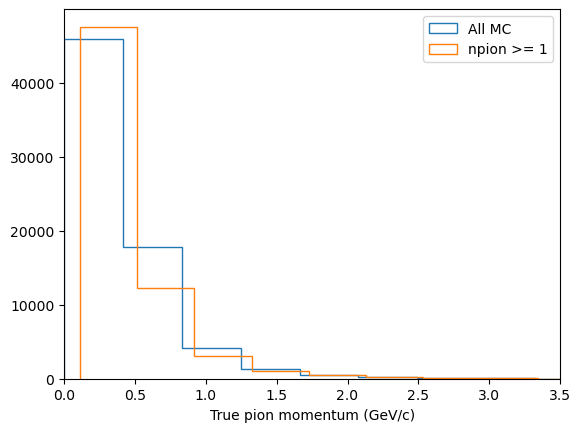

In [16]:
# Investigating how the 'npion' variable is defined - threshold is above 0.1 (0.1125) GeV/c

all_mc = pd.concat([df for k, df in rundata.items() if k!='data' or k!='ext'])
plt.hist(all_mc['mc_pion_p'], histtype='step', label='All MC')
all_mc.query('npion >= 1', inplace=True)
plt.hist(all_mc['mc_pion_p'], histtype='step', label='npion >= 1')
plt.legend()
plt.xlim([0,3.5])
#plt.grid(visible=True, which='both', axis='x')
plt.xlabel('True pion momentum (GeV/c)')

In [6]:
all_predict.loc[:, ['interaction']].head()

,interaction
entry,
179,-2147483648
291,-2147483648
594,-2147483648
664,-2147483648
780,-2147483648


In [4]:
all_predict = pd.concat([df for k, df in rundata.items() if k!='data'])
all_predict.loc[:, ['trk_energy', 'trk_id', 'mod_trk_p', 'trk_dir_x_v', 'trk_px','trk_dir_y_v', 'trk_py','trk_dir_z_v','trk_pz']].head(20)

,trk_energy,trk_id,mod_trk_p,trk_dir_x_v,trk_px,trk_dir_y_v,trk_py,trk_dir_z_v,trk_pz
entry,,,,,,,,,
0,0.000000,0,0.000000,[0.47086182],NaN,[0.8216522],NaN,[0.32121173],NaN
1,0.158715,2,0.568278,"[-0.29305825, -0.07713298, 0.5054329, -0.04046...",-0.043833,"[0.95549864, 0.99698377, -0.7406513, 0.2660279]",0.566564,"[0.033752203, -0.008605935, 0.44268864, 0.9631...",-0.004891
2,0.680067,1,1.318445,"[-0.21607879, -0.09295654, 0.19567071, 0.38058...",-0.284888,"[0.8527872, 0.9956281, -0.87326646, 0.8747957]",1.124353,"[0.47546184, -0.009155273, -0.44622716, 0.2998...",0.626870
3,0.000000,0,0.000000,"[-0.37325746, -0.20408146]",NaN,"[-0.5028064, -0.2490099]",NaN,"[0.77965677, 0.9467549]",NaN
4,0.039126,4,0.273737,"[0.3062771, 0.11935401, -0.77638704, 0.7071299]",0.193568,"[-0.8826664, -0.62572306, 0.17135137, -0.4155581]",-0.113754,"[-0.35650283, 0.77086014, -0.60651624, 0.5720829]",0.156600
5,0.000000,0,0.000000,[-0.44385576],NaN,[0.8343391],NaN,[0.32691026],NaN
6,0.116609,1,0.482033,"[0.4558788, 0.28459296, -0.08758652, -0.138338...",0.219748,"[0.7450221, 0.9252285, -0.49041587, 0.2688405,...",0.359125,"[0.48694617, 0.25091666, 0.8670761, -0.9531985...",0.234724
7,0.408838,2,0.966503,"[0.5405732, 0.5582728, -0.33546454, 0.09189585]",0.539572,"[0.832512, 0.75635266, 0.72903454, -0.44100088]",0.731017,"[-0.12126161, 0.34097257, 0.59663403, 0.8927897]",0.329551
8,0.025314,2,0.219387,"[0.86902124, -0.3038644]",-0.066664,"[0.4905749, -0.054161225]",-0.011882,"[0.06433069, 0.95117456]",0.208675


In [4]:
# Calculating efficiency and purity for TKI variables

from microfit import selections as sel

selection = "OnePL"
preselection = "OneP"
query = f"{sel.preselection_categories[preselection]['query']} and {sel.selection_categories[selection]['query']}"
#print(query)

all_predict = pd.concat([df for k, df in rundata.items() if k!='data']).query(query, engine='python')
#all_predict.head()

is_sig = all_predict['category_1e1p'] == 12
tot_sig = np.sum(all_predict.loc[is_sig, 'weights'])
tot_bkg = np.sum(all_predict.loc[~is_sig, 'weights'])
tot_evt = np.sum(all_predict['weights'])
print('Total signal events:', tot_sig)
print('Total background events:', tot_bkg)
print('Total events:', tot_evt)
print('sig + bkg =', tot_sig+tot_bkg)

for binning_def in vdef.TKI_variables_1e1p:
#     lb = binning_def[2][0]
#     ub = binning_def[2][1]
#     print(lb, ub)
    
    x_plot = np.linspace(binning_def[2][0], binning_def[2][1], 100)
    eff = []
    pur = []
    bkg_eff = []
    
    for x in x_plot:
        sig_below = np.sum(all_predict.loc[is_sig & (all_predict[binning_def[0]] < x), 'weights'])
        bkg_below = np.sum(all_predict.loc[~is_sig & (all_predict[binning_def[0]] < x), 'weights'])
        
        eff.append(sig_below/tot_sig)
        pur.append(sig_below/(sig_below + bkg_below))
        bkg_eff.append(bkg_below/tot_bkg)
        
    
    fig1, ax1 = plt.subplots()
    ax1.plot(x_plot, pur, label='signal purity')
    ax1.plot(x_plot, eff, label='signal efficiency')
    ax1.plot(x_plot, bkg_eff, label='background efficiency')
    ax1.legend()
    ax1.set_xlabel(binning_def[3])
    #plt.ylabel('Signal Efficiency')
    ax1.set_title('1e1p Presel. and 1e1p Loose cuts')
    #plt.tight_layout()
    plt.savefig('plots/pur_eff_TKI_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()
    
    fig2, ax2 = plt.subplots()
    ax2.plot(eff, pur)
    ax2.set_xlabel('Signal Efficiency')
    ax2.set_ylabel('Signal Purity')
    ax2.set_title('%s' %(binning_def[0]))
    #plt.tight_layout()
    plt.savefig('plots/eff_vs_pur_TKI_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()
    
    plt.plot(eff, bkg_eff)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Acceptance efficiency')
    plt.title('%s' %(binning_def[0]))
    plt.tight_layout()
    plt.savefig('plots/roc_TKI_microfit_1e1p_%s.pdf' %(binning_def[0]), bbox_inches='tight')
    
    plt.clf()

Total signal events: 120.58164011496757
Total background events: 40.932832351731456
Total events: 161.51447246669903
sig + bkg = 161.51447246669903


/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/uboone/app/users/cthorpe/Mambaforge/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>